# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import os

In [3]:
current_path = "/content/drive/MyDrive/ERA_V1/era_v1_session9_pankaja"
current_path

'/content/drive/MyDrive/ERA_V1/era_v1_session9_pankaja'

In [4]:
os.chdir(current_path)
os.getcwd()

'/content/drive/MyDrive/ERA_V1/era_v1_session9_pankaja'

In [5]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-bamp6uur
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-bamp6uur
  Resolved https://github.com/albumentations-team/albumentations.git to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=ccc8f98a32c61c407c24d956d7fa8f441a910936ca66c62065aae664eb62c8b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-fwrixucc/wheels/f9/34/b6/eb7adf92e69b5629d7de6904c0d4ac4e5050b18ce065bab4e1
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [6]:
from __future__ import print_function
import numpy as np
from utils import plot_metrics, train, test, helper
from models import model, model_fc
import torch
from pprint import pprint

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

import torchvision
from torchsummary import summary
from dataloader.load_data import Cifar10DataLoader
from utils.engine import TriggerEngine


## Load config file

In [7]:
config = helper.process_config("./config/config.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'args': {'cutout_prob': 0.5,
                                'horizontalflip_prob': 0.2,
                                'num_holes': 1,
                                'rotate_limit': 15,
                                'shiftscalerotate_prob': 0.25},
                       'type': 'albumentation'},
 'data_loader': {'args': {'batch_size': 256,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'CIFAR10DataLoader'},
 'model': 'cifar10',
 'model_params': {'dr

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
model = model.Net(0.01).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,080
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
             ReLU-12           [-1, 32, 32, 32]               0
      BatchNorm2d-13           [-1, 32, 32, 32]              64
        Dropout2d-14           [-1, 32,

In [ ]:
# FC layer - to be TESTED
# model_2 = model_fc.Net2(0.01).to(device)
# summary(model_2, input_size=(3, 32, 32))

## Download data and view sample images

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


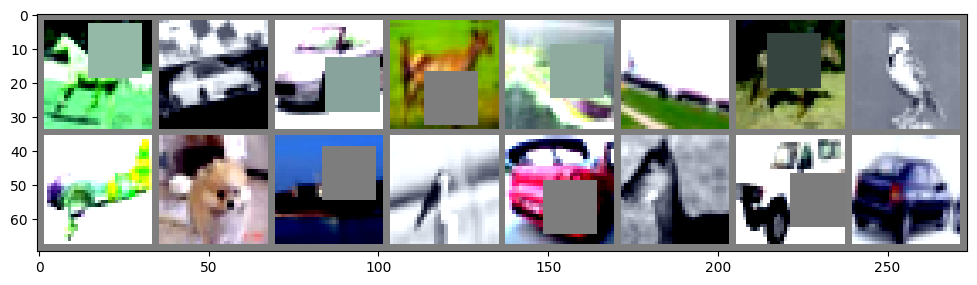

In [10]:
# functions to show an image
cifar_dataset = Cifar10DataLoader(config)
classes= config['data_loader']['classes']
fig, ax = plt.subplots(figsize=(12, 12))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


try:
  # get some random training images
  dataiter = iter(cifar_dataset.train_loader)
  images, labels = next(dataiter)

  # show images
  imshow(torchvision.utils.make_grid(images[:16]))
except Exception as ex:
  print(f"Error occurred: {ex}")


## Trigger training

In [ ]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']

trigger_training = TriggerEngine(config)

# trigger_training.
(exp_metrics[experiment_name]), model_a = trigger_training.run_experiment()
trigger_training.save_experiment(model_a,experiment_name)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1:


Loss=1.7863439321517944 Batch_id=195 LR=0.00043 Accuracy=29.38: 100%|██████████| 196/196 [00:13<00:00, 14.12it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 4407/10000 (44.07%)

Epoch 2:


Loss=1.643991470336914 Batch_id=195 LR=0.00053 Accuracy=42.44: 100%|██████████| 196/196 [00:13<00:00, 14.37it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 5130/10000 (51.30%)

Epoch 3:


Loss=1.4447150230407715 Batch_id=195 LR=0.00069 Accuracy=48.77: 100%|██████████| 196/196 [00:13<00:00, 14.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 5721/10000 (57.21%)

Epoch 4:


Loss=1.2343745231628418 Batch_id=195 LR=0.00091 Accuracy=53.99: 100%|██████████| 196/196 [00:13<00:00, 14.38it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 6246/10000 (62.46%)

Epoch 5:


Loss=1.2901214361190796 Batch_id=195 LR=0.00119 Accuracy=57.89: 100%|██████████| 196/196 [00:13<00:00, 14.13it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 6572/10000 (65.72%)

Epoch 6:


Loss=1.2879852056503296 Batch_id=195 LR=0.00152 Accuracy=60.58: 100%|██████████| 196/196 [00:13<00:00, 14.27it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 6807/10000 (68.07%)

Epoch 7:


Loss=0.9529579877853394 Batch_id=195 LR=0.00191 Accuracy=62.38: 100%|██████████| 196/196 [00:13<00:00, 14.29it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 7089/10000 (70.89%)

Epoch 8:


Loss=1.1316957473754883 Batch_id=195 LR=0.00233 Accuracy=63.88: 100%|██████████| 196/196 [00:13<00:00, 14.27it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 6908/10000 (69.08%)

Epoch 9:


Loss=1.1035102605819702 Batch_id=195 LR=0.00280 Accuracy=65.05: 100%|██████████| 196/196 [00:14<00:00, 13.95it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7216/10000 (72.16%)

Epoch 10:


Loss=0.9383977055549622 Batch_id=195 LR=0.00330 Accuracy=65.97: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7209/10000 (72.09%)

Epoch 11:


Loss=1.2825467586517334 Batch_id=195 LR=0.00382 Accuracy=66.89: 100%|██████████| 196/196 [00:14<00:00, 13.68it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 7314/10000 (73.14%)

Epoch 12:


Loss=0.9280669093132019 Batch_id=195 LR=0.00437 Accuracy=67.55: 100%|██████████| 196/196 [00:14<00:00, 13.65it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7533/10000 (75.33%)

Epoch 13:


Loss=0.8591944575309753 Batch_id=195 LR=0.00492 Accuracy=68.07: 100%|██████████| 196/196 [00:14<00:00, 13.62it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 7247/10000 (72.47%)

Epoch 14:


Loss=1.035975694656372 Batch_id=195 LR=0.00548 Accuracy=68.53: 100%|██████████| 196/196 [00:14<00:00, 13.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7504/10000 (75.04%)

Epoch 15:


Loss=0.8850709795951843 Batch_id=195 LR=0.00604 Accuracy=69.02: 100%|██████████| 196/196 [00:13<00:00, 14.11it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7570/10000 (75.70%)

Epoch 16:


Loss=0.9050224423408508 Batch_id=195 LR=0.00658 Accuracy=69.56: 100%|██████████| 196/196 [00:13<00:00, 14.12it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7583/10000 (75.83%)

Epoch 17:


Loss=0.789880633354187 Batch_id=195 LR=0.00710 Accuracy=69.55: 100%|██████████| 196/196 [00:13<00:00, 14.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7575/10000 (75.75%)

Epoch 18:


Loss=1.0201544761657715 Batch_id=195 LR=0.00760 Accuracy=69.59: 100%|██████████| 196/196 [00:14<00:00, 13.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7548/10000 (75.48%)

Epoch 19:


Loss=0.7376900315284729 Batch_id=195 LR=0.00807 Accuracy=70.00: 100%|██████████| 196/196 [00:14<00:00, 13.95it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7612/10000 (76.12%)

Epoch 20:


Loss=1.0414338111877441 Batch_id=195 LR=0.00850 Accuracy=70.55: 100%|██████████| 196/196 [00:13<00:00, 14.13it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 7360/10000 (73.60%)

Epoch 21:


Loss=0.7892434000968933 Batch_id=195 LR=0.00888 Accuracy=70.49: 100%|██████████| 196/196 [00:14<00:00, 13.85it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 7429/10000 (74.29%)

Epoch 22:


Loss=0.9433385133743286 Batch_id=195 LR=0.00921 Accuracy=70.69: 100%|██████████| 196/196 [00:13<00:00, 14.21it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7501/10000 (75.01%)

Epoch 23:


Loss=0.7301747798919678 Batch_id=195 LR=0.00949 Accuracy=70.91: 100%|██████████| 196/196 [00:13<00:00, 14.11it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7590/10000 (75.90%)

Epoch 24:


Loss=0.7873011827468872 Batch_id=195 LR=0.00971 Accuracy=71.13: 100%|██████████| 196/196 [00:13<00:00, 14.04it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7566/10000 (75.66%)

Epoch 25:


Loss=1.0374395847320557 Batch_id=195 LR=0.00987 Accuracy=71.22: 100%|██████████| 196/196 [00:14<00:00, 13.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7663/10000 (76.63%)

Epoch 26:


Loss=0.7670177221298218 Batch_id=195 LR=0.00997 Accuracy=71.32: 100%|██████████| 196/196 [00:13<00:00, 14.02it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7750/10000 (77.50%)

Epoch 27:


Loss=0.8616105318069458 Batch_id=195 LR=0.01000 Accuracy=71.37: 100%|██████████| 196/196 [00:14<00:00, 13.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7646/10000 (76.46%)

Epoch 28:


Loss=0.8340059518814087 Batch_id=195 LR=0.00999 Accuracy=71.62: 100%|██████████| 196/196 [00:14<00:00, 13.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 7442/10000 (74.42%)

Epoch 29:


Loss=0.7241061925888062 Batch_id=195 LR=0.00998 Accuracy=71.75: 100%|██████████| 196/196 [00:14<00:00, 13.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7735/10000 (77.35%)

Epoch 30:


Loss=0.6961734890937805 Batch_id=195 LR=0.00994 Accuracy=71.98: 100%|██████████| 196/196 [00:14<00:00, 13.94it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7581/10000 (75.81%)

Epoch 31:


Loss=0.8051748275756836 Batch_id=195 LR=0.00990 Accuracy=72.05: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7586/10000 (75.86%)

Epoch 32:


Loss=0.7151428461074829 Batch_id=195 LR=0.00985 Accuracy=72.07: 100%|██████████| 196/196 [00:14<00:00, 13.88it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7687/10000 (76.87%)

Epoch 33:


Loss=1.0243922472000122 Batch_id=195 LR=0.00978 Accuracy=71.90: 100%|██████████| 196/196 [00:14<00:00, 13.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 7807/10000 (78.07%)

Epoch 34:


Loss=0.7045131325721741 Batch_id=195 LR=0.00970 Accuracy=72.31: 100%|██████████| 196/196 [00:14<00:00, 13.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 7715/10000 (77.15%)

Epoch 35:


Loss=1.063346266746521 Batch_id=195 LR=0.00961 Accuracy=72.18: 100%|██████████| 196/196 [00:14<00:00, 13.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7492/10000 (74.92%)

Epoch 36:


Loss=0.952379584312439 Batch_id=195 LR=0.00950 Accuracy=72.33: 100%|██████████| 196/196 [00:14<00:00, 13.95it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 7832/10000 (78.32%)

Epoch 37:


Loss=0.7040458917617798 Batch_id=195 LR=0.00939 Accuracy=72.28: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7624/10000 (76.24%)

Epoch 38:


Loss=1.0554664134979248 Batch_id=195 LR=0.00927 Accuracy=72.52: 100%|██████████| 196/196 [00:14<00:00, 13.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 7938/10000 (79.38%)

Epoch 39:


Loss=0.7914034128189087 Batch_id=195 LR=0.00913 Accuracy=72.71: 100%|██████████| 196/196 [00:13<00:00, 14.11it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7777/10000 (77.77%)

Epoch 40:


Loss=0.7701900005340576 Batch_id=195 LR=0.00898 Accuracy=72.85: 100%|██████████| 196/196 [00:13<00:00, 14.04it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7593/10000 (75.93%)

Epoch 41:


Loss=0.8713725209236145 Batch_id=195 LR=0.00883 Accuracy=73.10: 100%|██████████| 196/196 [00:13<00:00, 14.05it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7710/10000 (77.10%)

Epoch 42:


Loss=0.8375059962272644 Batch_id=195 LR=0.00866 Accuracy=72.86: 100%|██████████| 196/196 [00:14<00:00, 13.99it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7669/10000 (76.69%)

Epoch 43:


Loss=0.7520014047622681 Batch_id=195 LR=0.00849 Accuracy=73.42: 100%|██████████| 196/196 [00:14<00:00, 13.93it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7681/10000 (76.81%)

Epoch 44:


Loss=0.6803322434425354 Batch_id=195 LR=0.00831 Accuracy=73.52: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7771/10000 (77.71%)

Epoch 45:


Loss=0.979954719543457 Batch_id=195 LR=0.00812 Accuracy=73.63: 100%|██████████| 196/196 [00:13<00:00, 14.05it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 7793/10000 (77.93%)

Epoch 46:


Loss=0.7672444581985474 Batch_id=195 LR=0.00792 Accuracy=73.62: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 7842/10000 (78.42%)

Epoch 47:


Loss=0.5693843364715576 Batch_id=195 LR=0.00771 Accuracy=73.86: 100%|██████████| 196/196 [00:13<00:00, 14.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 7719/10000 (77.19%)

Epoch 48:


Loss=0.7910192012786865 Batch_id=195 LR=0.00750 Accuracy=74.16: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 7882/10000 (78.82%)

Epoch 49:


Loss=0.6887952089309692 Batch_id=195 LR=0.00728 Accuracy=74.19: 100%|██████████| 196/196 [00:14<00:00, 13.99it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8078/10000 (80.78%)

Epoch 50:


Loss=0.7709396481513977 Batch_id=195 LR=0.00706 Accuracy=74.63: 100%|██████████| 196/196 [00:14<00:00, 13.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8048/10000 (80.48%)

Epoch 51:


Loss=0.7380024790763855 Batch_id=195 LR=0.00683 Accuracy=74.62: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8095/10000 (80.95%)

Epoch 52:


Loss=0.7158113121986389 Batch_id=195 LR=0.00659 Accuracy=74.97: 100%|██████████| 196/196 [00:14<00:00, 13.84it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8081/10000 (80.81%)

Epoch 53:


Loss=0.8777079582214355 Batch_id=195 LR=0.00635 Accuracy=74.98: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8171/10000 (81.71%)

Epoch 54:


Loss=0.6576747894287109 Batch_id=195 LR=0.00611 Accuracy=75.12: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8070/10000 (80.70%)

Epoch 55:


Loss=0.6961812376976013 Batch_id=195 LR=0.00587 Accuracy=75.47: 100%|██████████| 196/196 [00:14<00:00, 13.98it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 7976/10000 (79.76%)

Epoch 56:


Loss=0.7732640504837036 Batch_id=195 LR=0.00562 Accuracy=75.66: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8040/10000 (80.40%)

Epoch 57:


Loss=0.7004727125167847 Batch_id=195 LR=0.00537 Accuracy=75.95: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8095/10000 (80.95%)

Epoch 58:


Loss=0.5610059499740601 Batch_id=195 LR=0.00512 Accuracy=76.26: 100%|██████████| 196/196 [00:14<00:00, 13.90it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8153/10000 (81.53%)

Epoch 59:


Loss=0.7649127840995789 Batch_id=195 LR=0.00487 Accuracy=76.49: 100%|██████████| 196/196 [00:14<00:00, 13.85it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8182/10000 (81.82%)

Epoch 60:


Loss=0.6742063760757446 Batch_id=195 LR=0.00463 Accuracy=76.61: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 8266/10000 (82.66%)

Epoch 61:


Loss=0.5821956396102905 Batch_id=195 LR=0.00438 Accuracy=76.97: 100%|██████████| 196/196 [00:14<00:00, 13.84it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 8208/10000 (82.08%)

Epoch 62:


Loss=0.5250812768936157 Batch_id=195 LR=0.00413 Accuracy=77.31: 100%|██████████| 196/196 [00:13<00:00, 14.06it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 8281/10000 (82.81%)

Epoch 63:


Loss=0.74607253074646 Batch_id=195 LR=0.00389 Accuracy=77.71: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 8333/10000 (83.33%)

Epoch 64:


Loss=0.697485089302063 Batch_id=195 LR=0.00364 Accuracy=77.57: 100%|██████████| 196/196 [00:13<00:00, 14.09it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 8375/10000 (83.75%)

Epoch 65:


Loss=0.8775724172592163 Batch_id=195 LR=0.00341 Accuracy=78.33: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 8266/10000 (82.66%)

Epoch 66:


Loss=0.5819722414016724 Batch_id=195 LR=0.00317 Accuracy=78.60: 100%|██████████| 196/196 [00:13<00:00, 14.02it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 8302/10000 (83.02%)

Epoch 67:


Loss=0.6700190901756287 Batch_id=195 LR=0.00294 Accuracy=78.92: 100%|██████████| 196/196 [00:14<00:00, 13.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 8411/10000 (84.11%)

Epoch 68:


Loss=0.6314150094985962 Batch_id=195 LR=0.00272 Accuracy=78.99: 100%|██████████| 196/196 [00:14<00:00, 13.95it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 8451/10000 (84.51%)

Epoch 69:


Loss=0.65234375 Batch_id=195 LR=0.00250 Accuracy=79.39: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 8489/10000 (84.89%)

Epoch 70:


Loss=0.7867509126663208 Batch_id=195 LR=0.00229 Accuracy=79.50: 100%|██████████| 196/196 [00:13<00:00, 14.04it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8547/10000 (85.47%)

Epoch 71:


Loss=0.7134128212928772 Batch_id=195 LR=0.00208 Accuracy=80.05: 100%|██████████| 196/196 [00:14<00:00, 13.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 8521/10000 (85.21%)

Epoch 72:


Loss=0.6725863218307495 Batch_id=195 LR=0.00188 Accuracy=80.33: 100%|██████████| 196/196 [00:14<00:00, 13.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 8519/10000 (85.19%)

Epoch 73:


Loss=0.5519553422927856 Batch_id=195 LR=0.00169 Accuracy=80.60: 100%|██████████| 196/196 [00:14<00:00, 13.86it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 8510/10000 (85.10%)

Epoch 74:


Loss=0.703879714012146 Batch_id=195 LR=0.00151 Accuracy=81.00: 100%|██████████| 196/196 [00:14<00:00, 13.97it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8569/10000 (85.69%)

Epoch 75:


Loss=0.6356183886528015 Batch_id=195 LR=0.00133 Accuracy=81.53: 100%|██████████| 196/196 [00:14<00:00, 13.93it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8579/10000 (85.79%)

Epoch 76:


Loss=0.40878304839134216 Batch_id=195 LR=0.00117 Accuracy=81.91: 100%|██████████| 196/196 [00:14<00:00, 13.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8640/10000 (86.40%)

Epoch 77:


Loss=0.647671103477478 Batch_id=195 LR=0.00101 Accuracy=82.02: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8668/10000 (86.68%)

Epoch 78:


Loss=0.4791182577610016 Batch_id=195 LR=0.00087 Accuracy=82.34: 100%|██████████| 196/196 [00:14<00:00, 13.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8647/10000 (86.47%)

Epoch 79:


Loss=0.3281199038028717 Batch_id=195 LR=0.00073 Accuracy=82.71: 100%|██████████| 196/196 [00:14<00:00, 13.86it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8681/10000 (86.81%)

Epoch 80:


Loss=0.7856395840644836 Batch_id=195 LR=0.00061 Accuracy=82.62: 100%|██████████| 196/196 [00:14<00:00, 13.07it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8671/10000 (86.71%)

Epoch 81:


Loss=0.5461487770080566 Batch_id=195 LR=0.00049 Accuracy=82.89: 100%|██████████| 196/196 [00:14<00:00, 13.43it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8687/10000 (86.87%)

Epoch 82:


Loss=0.49185818433761597 Batch_id=195 LR=0.00039 Accuracy=83.29: 100%|██████████| 196/196 [00:14<00:00, 13.33it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8715/10000 (87.15%)

Epoch 83:


Loss=0.48239773511886597 Batch_id=195 LR=0.00030 Accuracy=83.20: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8695/10000 (86.95%)

Epoch 84:


Loss=0.5658267736434937 Batch_id=195 LR=0.00022 Accuracy=83.42: 100%|██████████| 196/196 [00:14<00:00, 13.91it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8727/10000 (87.27%)

Epoch 85:


Loss=0.3897304832935333 Batch_id=195 LR=0.00015 Accuracy=83.61: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 8734/10000 (87.34%)

Epoch 86:


Loss=0.5429454445838928 Batch_id=195 LR=0.00010 Accuracy=83.67: 100%|██████████| 196/196 [00:14<00:00, 13.45it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8746/10000 (87.46%)

Epoch 87:


Loss=0.39605605602264404 Batch_id=195 LR=0.00006 Accuracy=83.65: 100%|██████████| 196/196 [00:14<00:00, 13.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8734/10000 (87.34%)

Epoch 88:


Loss=0.5205503702163696 Batch_id=195 LR=0.00002 Accuracy=83.92: 100%|██████████| 196/196 [00:14<00:00, 13.48it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8755/10000 (87.55%)

Epoch 89:


Loss=0.4781967103481293 Batch_id=195 LR=0.00001 Accuracy=83.62: 100%|██████████| 196/196 [00:14<00:00, 13.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8752/10000 (87.52%)

Epoch 90:


Loss=0.4473210275173187 Batch_id=195 LR=0.00000 Accuracy=83.91: 100%|██████████| 196/196 [00:14<00:00, 13.37it/s]



Test set: Average loss: 0.0016, Accuracy: 8743/10000 (87.43%)

Saving the model for cifar10_with_advancedconv


## Model summary

In [ ]:
trigger_training.model_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           2,080
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,

## Missclassification

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total wrong predictions are 1257


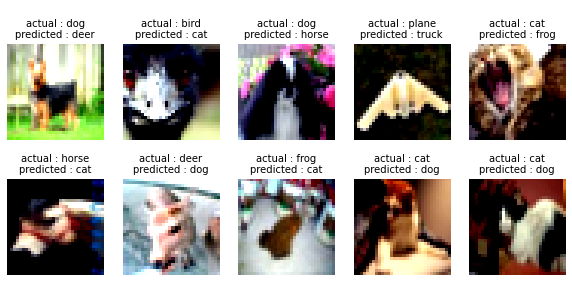

In [ ]:
model = torch.load(f'./saved_models/{experiment_name}.pt')
model.eval()
trigger_training.wrong_predictions(model)

## Plots for Validation Loss and Accuracy

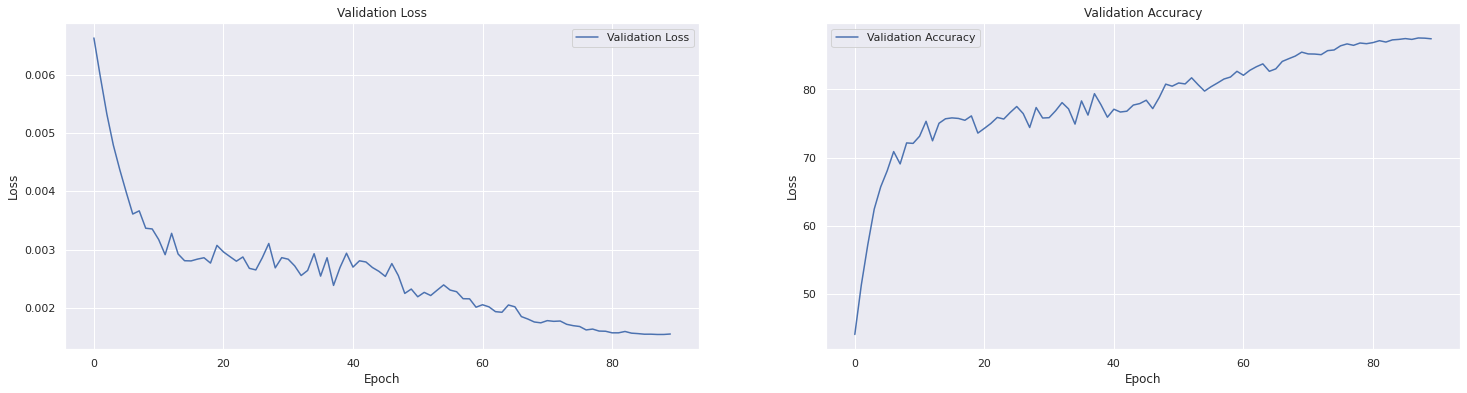

In [ ]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

## Accuracy for each class

In [ ]:
helper.class_level_accuracy(model, cifar_dataset.test_loader, device, classes)

Accuracy of plane : 89 %
Accuracy of   car : 95 %
Accuracy of  bird : 81 %
Accuracy of   cat : 70 %
Accuracy of  deer : 86 %
Accuracy of   dog : 79 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %
